In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)

1.7.0


In [3]:
#Multi-Layer Perceptron Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 500) 
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
        

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))   
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


MLP_network = MLP()

In [4]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(MLP_network.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-08, weight_decay=0.001)

In [5]:
# transforms to apply to the Fashion mnist data
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Fashion MNIST dataset
fashion_trainset = datasets.FashionMNIST(root='./fmnist/', train=True, download=True, transform=transform)

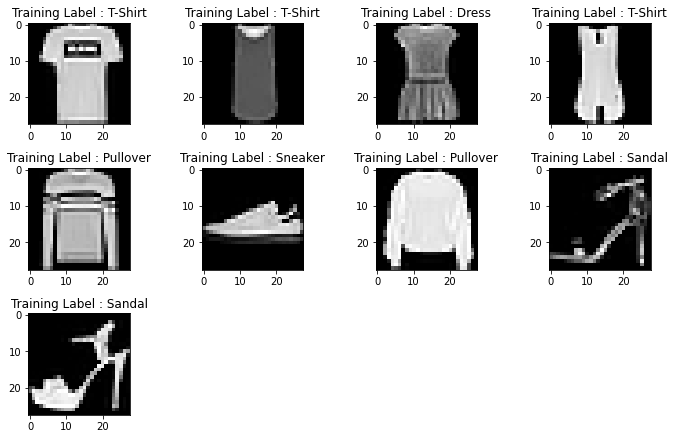

In [6]:
labels_map = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle Boot')
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(fashion_trainset.train_data[i].numpy(), cmap='gray')
    plt.title('Training Label : %s' % labels_map[fashion_trainset.train_labels[i]])
plt.show()

In [7]:
num_train = len(fashion_trainset)
indices = list(range(num_train))
# Splitting the Dataset into 10% Training set and 90% Validation Set
split = 54000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

In [8]:
# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replaf
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader1 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=train_sampler)

validation_loader1 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=validation_sampler)

In [9]:
#MLP on 10% of the Training Dataset
num_epochs = 20
total_step = len(train_loader1)
Loss_f1 = []
print('----------------------------------------------------')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader1, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_f1.append(running_loss / total_step)
print('Finished Training')

----------------------------------------------------
Epoch 1  | Loss : 0.7139
----------------------------------------------------
Epoch 2  | Loss : 0.5188
----------------------------------------------------
Epoch 3  | Loss : 0.4556
----------------------------------------------------
Epoch 4  | Loss : 0.4179
----------------------------------------------------
Epoch 5  | Loss : 0.3959
----------------------------------------------------
Epoch 6  | Loss : 0.3714
----------------------------------------------------
Epoch 7  | Loss : 0.3562
----------------------------------------------------
Epoch 8  | Loss : 0.3400
----------------------------------------------------
Epoch 9  | Loss : 0.3269
----------------------------------------------------
Epoch 10  | Loss : 0.3165
----------------------------------------------------
Epoch 11  | Loss : 0.3101
----------------------------------------------------
Epoch 12  | Loss : 0.2929
----------------------------------------------------
Epoch 13

In [10]:
#Accuracy of 90% of the Validation Test Dataset
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader1:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 54000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 54000 test images: 83 %


In [11]:
MLP_network.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_loader1:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of class %5s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 68 %
Accuracy of class Trouser : 97 %
Accuracy of class Pullover : 68 %
Accuracy of class Dress : 67 %
Accuracy of class  Coat : 88 %
Accuracy of class Sandal : 94 %
Accuracy of class Shirt : 67 %
Accuracy of class Sneaker : 90 %
Accuracy of class   Bag : 92 %
Accuracy of class Ankle Boot : 93 %


In [13]:
# 20 : 80
num_train = len(fashion_trainset)
indices = list(range(num_train))
#Splitting the Dataset into 20% Training set and 80% Validation Set
split = 48000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replaf
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader2 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=train_sampler)

validation_loader2 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=validation_sampler)

In [14]:
#MLP on 20% of the Training Dataset
num_epochs = 20
total_step = len(train_loader2)
Loss_f2 = []
print('----------------------------------------------------')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader2, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_f2.append(running_loss / total_step)
print('Finished Training')

----------------------------------------------------
Epoch 1  | Loss : 0.4169
----------------------------------------------------
Epoch 2  | Loss : 0.3711
----------------------------------------------------
Epoch 3  | Loss : 0.3515
----------------------------------------------------
Epoch 4  | Loss : 0.3419
----------------------------------------------------
Epoch 5  | Loss : 0.3272
----------------------------------------------------
Epoch 6  | Loss : 0.3172
----------------------------------------------------
Epoch 7  | Loss : 0.3074
----------------------------------------------------
Epoch 8  | Loss : 0.2968
----------------------------------------------------
Epoch 9  | Loss : 0.2969
----------------------------------------------------
Epoch 10  | Loss : 0.2898
----------------------------------------------------
Epoch 11  | Loss : 0.2848
----------------------------------------------------
Epoch 12  | Loss : 0.2842
----------------------------------------------------
Epoch 13

In [15]:
#Accuracy of 80% of the Validation Test Dataset
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader2:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 48000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 48000 test images: 85 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_loader2:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of class %5s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 83 %
Accuracy of class Trouser : 96 %
Accuracy of class Pullover : 76 %
Accuracy of class Dress : 88 %
Accuracy of class  Coat : 83 %
Accuracy of class Sandal : 91 %
Accuracy of class Shirt : 65 %
Accuracy of class Sneaker : 85 %
Accuracy of class   Bag : 94 %
Accuracy of class Ankle Boot : 97 %


In [19]:
num_train = len(fashion_trainset)
indices = list(range(num_train))
#Splitting the Dataset into 30% Training set and 70% Validation Set
split = 42000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replaf
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader3 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=train_sampler)

validation_loader3 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=validation_sampler)

In [20]:
#MLP on 30% of the Training Dataset
num_epochs = 20
total_step = len(train_loader3)
Loss_f3 = []
print('----------------------------------------------------')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader3, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_f3.append(running_loss / total_step)
print('Finished Training')

----------------------------------------------------
Epoch 1  | Loss : 0.3860
----------------------------------------------------
Epoch 2  | Loss : 0.3564
----------------------------------------------------
Epoch 3  | Loss : 0.3354
----------------------------------------------------
Epoch 4  | Loss : 0.3309
----------------------------------------------------
Epoch 5  | Loss : 0.3213
----------------------------------------------------
Epoch 6  | Loss : 0.3196
----------------------------------------------------
Epoch 7  | Loss : 0.3153
----------------------------------------------------
Epoch 8  | Loss : 0.3092
----------------------------------------------------
Epoch 9  | Loss : 0.3069
----------------------------------------------------
Epoch 10  | Loss : 0.2973
----------------------------------------------------
Epoch 11  | Loss : 0.3000
----------------------------------------------------
Epoch 12  | Loss : 0.2978
----------------------------------------------------
Epoch 13

In [21]:
#Accuracy of 70% of the Validation Test Dataset
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader3:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 42000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 42000 test images: 86 %


In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_loader3:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of class %5s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 81 %
Accuracy of class Trouser : 97 %
Accuracy of class Pullover : 72 %
Accuracy of class Dress : 90 %
Accuracy of class  Coat : 85 %
Accuracy of class Sandal : 94 %
Accuracy of class Shirt : 62 %
Accuracy of class Sneaker : 92 %
Accuracy of class   Bag : 96 %
Accuracy of class Ankle Boot : 93 %


In [23]:
num_train = len(fashion_trainset)
indices = list(range(num_train))
#Splitting the Dataset into 40% Training set and 60% Validation Set
split = 36000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replaf
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader4 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=train_sampler)

validation_loader4 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=validation_sampler)

In [24]:
#MLP on 40% of the Training Dataset
num_epochs = 20
total_step = len(train_loader4)
Loss_f4 = []
print('----------------------------------------------------')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader4, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_f4.append(running_loss / total_step)
print('Finished Training')

----------------------------------------------------
Epoch 1  | Loss : 0.3709
----------------------------------------------------
Epoch 2  | Loss : 0.3405
----------------------------------------------------
Epoch 3  | Loss : 0.3313
----------------------------------------------------
Epoch 4  | Loss : 0.3242
----------------------------------------------------
Epoch 5  | Loss : 0.3189
----------------------------------------------------
Epoch 6  | Loss : 0.3170
----------------------------------------------------
Epoch 7  | Loss : 0.3127
----------------------------------------------------
Epoch 8  | Loss : 0.3098
----------------------------------------------------
Epoch 9  | Loss : 0.3106
----------------------------------------------------
Epoch 10  | Loss : 0.3085
----------------------------------------------------
Epoch 11  | Loss : 0.3090
----------------------------------------------------
Epoch 12  | Loss : 0.3078
----------------------------------------------------
Epoch 13

In [25]:
#Accuracy of 60% of the Validation Test Dataset
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader4:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 36000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 36000 test images: 85 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_loader4:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of class %5s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 82 %
Accuracy of class Trouser : 95 %
Accuracy of class Pullover : 74 %
Accuracy of class Dress : 79 %
Accuracy of class  Coat : 66 %
Accuracy of class Sandal : 93 %
Accuracy of class Shirt : 73 %
Accuracy of class Sneaker : 90 %
Accuracy of class   Bag : 96 %
Accuracy of class Ankle Boot : 96 %


In [27]:
num_train = len(fashion_trainset)
indices = list(range(num_train))
#Splitting the Dataset into 50% Training set and 50% Validation Set
split = 30000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replaf
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader5 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=train_sampler)

validation_loader5 = torch.utils.data.DataLoader(fashion_trainset, batch_size=10, sampler=validation_sampler)


In [28]:
#MLP on 50% of the Training Dataset
num_epochs = 20
total_step = len(train_loader5)
Loss_f5 = []
print('----------------------------------------------------')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader5, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_f5.append(running_loss / total_step)
print('Finished Training')

----------------------------------------------------
Epoch 1  | Loss : 0.3525
----------------------------------------------------
Epoch 2  | Loss : 0.3377
----------------------------------------------------
Epoch 3  | Loss : 0.3346
----------------------------------------------------
Epoch 4  | Loss : 0.3293
----------------------------------------------------
Epoch 5  | Loss : 0.3248
----------------------------------------------------
Epoch 6  | Loss : 0.3212
----------------------------------------------------
Epoch 7  | Loss : 0.3199
----------------------------------------------------
Epoch 8  | Loss : 0.3200
----------------------------------------------------
Epoch 9  | Loss : 0.3171
----------------------------------------------------
Epoch 10  | Loss : 0.3189
----------------------------------------------------
Epoch 11  | Loss : 0.3190
----------------------------------------------------
Epoch 12  | Loss : 0.3141
----------------------------------------------------
Epoch 13

In [29]:
#Accuracy of 50% of the Validation Test Dataset
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader5:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 30000 test images: 86 %


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_loader5:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of class %5s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class T-Shirt : 80 %
Accuracy of class Trouser : 96 %
Accuracy of class Pullover : 84 %
Accuracy of class Dress : 91 %
Accuracy of class  Coat : 79 %
Accuracy of class Sandal : 95 %
Accuracy of class Shirt : 58 %
Accuracy of class Sneaker : 91 %
Accuracy of class   Bag : 93 %
Accuracy of class Ankle Boot : 95 %


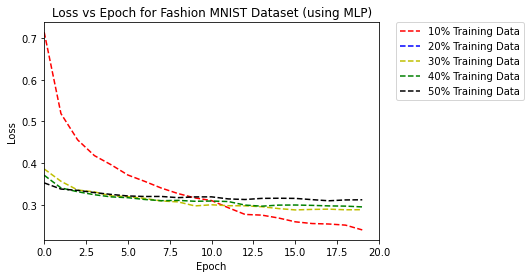

In [31]:
plt.plot(Loss_f1, 'r--', label = "10% Training Data")
plt.plot(Loss_f2, 'b--', label = "20% Training Data")
plt.plot(Loss_f3, 'y--', label = "30% Training Data")
plt.plot(Loss_f4, 'g--', label = "40% Training Data")
plt.plot(Loss_f5, 'k--', label = "50% Training Data")
plt.title("Loss vs Epoch for Fashion MNIST Dataset (using MLP)")
plt.xlim([0, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()